In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Impostiamo un seed per la riproducibilità
np.random.seed(42)

df = pd.read_csv('ordini_cleaned.csv')
df['Data_mat'] = pd.to_datetime(df['Data_mat'])
df = df.drop(['Data_ricarica','Unnamed: 0.1','Unnamed: 0','C_CLI','Nominativo'],axis = 1)


C:\Users\antonio.proietti\AppData\Local\Temp\ipykernel_24436\2438607616.py:11: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ordini_cleaned.csv')


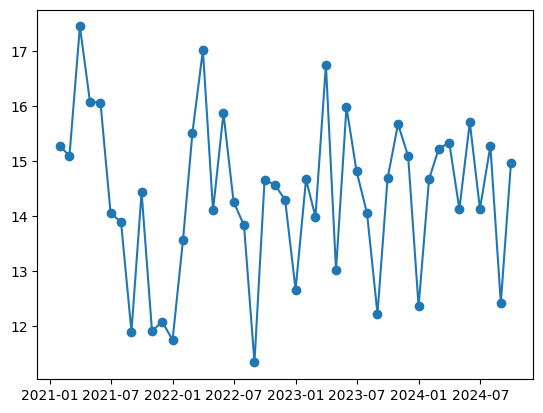

In [13]:
df_grouped = df.groupby('Data_mat').mean('Qt').reset_index()
plt.plot(df_grouped['Data_mat'],df_grouped['Qt'],marker = 'o')
plt.xlabel = 'Periodo'
plt.ylabel = 'media quantità'
plt.show()


In [14]:
df.head()

,Azieda,CID,Qt,Valore,Data_mat,SEDE_DI_LAVORO
0,A2A AIRPORT ENERGY SPA,64799,20,900,2023-10-31,LINATE - AEROPORTO
1,A2A AIRPORT ENERGY SPA,64800,19,900,2023-10-31,MALPENSA - AEROPORTO
2,A2A AIRPORT ENERGY SPA,64801,17,900,2023-10-31,MALPENSA - AEROPORTO
3,A2A AIRPORT ENERGY SPA,64802,1,700,2023-10-31,MALPENSA - AEROPORTO
4,A2A AIRPORT ENERGY SPA,64802,18,900,2023-10-31,MALPENSA - AEROPORTO


In [19]:
strings = ['Azieda', 'SEDE_DI_LAVORO','CID','Valore']
for i in strings:
    df[i] = df[i].astype(str)

In [24]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols = strings)
# Creiamo un DataFrame con le variabili codificate
edf_encoded = encoder.fit_transform(df[strings], df['Qt'])

# Visualizza il DataFrame codificato
print(edf_encoded.head())


      Azieda  SEDE_DI_LAVORO        CID     Valore
0  17.401575       17.270042  16.875131  17.133101
1  17.401575       17.520513  16.875131  17.133101
2  17.401575       17.520513  16.375151  17.133101
3  17.401575       17.520513  16.740292  12.906468
4  17.401575       17.520513  16.740292  17.133101


In [25]:
df[strings] = edf_encoded
df.head()

,Azieda,CID,Qt,Valore,Data_mat,SEDE_DI_LAVORO
0,17.401575,16.875131,20,17.133101,2023-10-31,17.270042
1,17.401575,16.875131,19,17.133101,2023-10-31,17.520513
2,17.401575,16.375151,17,17.133101,2023-10-31,17.520513
3,17.401575,16.740292,1,12.906468,2023-10-31,17.520513
4,17.401575,16.740292,18,17.133101,2023-10-31,17.520513


In [26]:
# Aggregazione dei dati per mese
df.set_index('Data_mat', inplace=True)
monthly_agg = df.resample('M').agg({
    'Qt': 'sum',  # Adatta a seconda di come chiami la variabile target
    # Aggiungi qui altre aggregazioni se necessario
})


In [30]:
for col in strings:  # dove strings è la lista delle colonne codificate
    monthly_agg[col] = df[col].resample('M').mean()

# Suddivisione in set di addestramento e di test
train, test = train_test_split(monthly_agg, test_size=0.2, random_state=42, shuffle=False)



In [32]:

# Implementazione del modello SARIMAX
model = SARIMAX(train['Qt'], 
                exog=train.drop(columns=['Qt']),  # Utilizza le colonne codificate come exog
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Previsione
n_steps = len(test)
predictions = model_fit.forecast(steps=n_steps, exog=test.drop(columns=['Qt']))

# Calcolo delle metriche di performance
rmse = mean_squared_error(test['Qt'], predictions, squared=False)
mae = mean_absolute_error(test['Qt'], predictions)

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')


c:\Users\antonio.proietti\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RMSE: 44341.29
MAE: 41765.12


In [34]:
df_grouped = df.groupby('Data_mat').sum('Qt')

In [38]:
df_grouped['Qt'].std()

29108.62052930698

In [45]:
df.columns

Index(['Azieda', 'CID', 'Qt', 'Valore', 'SEDE_DI_LAVORO'], dtype='object')